# Predicting differences between local and benchmark decisions

This experiment focuses on hospitals who would give thrombolysis to at least 50% more patients if the majority vote of 30 benchmark hospitals were applied. We build a model to predict those patients, out of patients who will be thrombolysed by the majority of the benchmark hospitals, who will thrombolysed at a local unit. 

The XGBoost model is fitted to 10 features:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

## Aims:

* Of all those patients thrombolysed by benchmark decision, build an XGBoost model to predict which patients, would be thrombolysed at a local unit.
* Investigate model predictions using Shap

## Observations

* We can predict those that will receive thrombolysis at a local unit, out of those who will be thrombolysed by the majority of the benchmark hospitals, with 67% accuracy (AUC 0.72).

* The five most important distinguishing features are:
    * Stroke severity
    * Prior disability
    * Precise onset time
    * Arrival to scan time
    * Onset to arrival time

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from xgboost import XGBClassifier

import shap

# Import local package
from utils import waterfall
# Force package to be reloaded
importlib.reload(waterfall);

## Function to calculate accuracy measures

In [2]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate: Same as specificity
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                            (np.sum(true_positives) + np.sum(false_positives)))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                            (np.sum(true_negatives) + np.sum(false_negatives)))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

## Set filenames

In [3]:
number_of_features_to_use = 10
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '06'

## Load data

In [4]:
thrombolysis_decision_data = pd.read_csv(
    './predictions/05_benchmark_decisions_combined_xgb_key_features.csv')

Add label where benchmark = 1, but observed = 0

In [5]:
thrombolysis_decision_data['benchmark_yes_observed_no'] = (
    (thrombolysis_decision_data['Benchmark majority vote'] == 1) &
    (thrombolysis_decision_data['Observed IVT'] == 0))

In [6]:
thrombolysis_decision_data

,Home hospital,Observed IVT,Predicted IVT,Predicted probability IVT,Benchmark majority vote,benchmark_yes_observed_no
0,TXHRP7672C,1,1,0.957469,1.0,False
1,SQGXB9559U,1,1,0.560687,1.0,False
2,LFPMM4706C,0,0,0.026418,0.0,False
3,MHMYL4920B,0,0,0.000148,0.0,False
4,EQZZZ5658G,1,1,0.907736,1.0,False
...,...,...,...,...,...,...
88787,OYASQ1316D,1,1,0.909366,1.0,False
88788,SMVTP6284P,0,0,0.029626,0.0,False
88789,RDVPJ0375X,0,0,0.068752,0.0,False
88790,FAJKD7118X,0,1,0.627094,1.0,True


Combine with feature data for patients.

In [7]:
feature_data = pd.read_csv(
    './predictions/05_test_features_collated_key_features.csv')
feature_data['benchmark_yes_observed_no'] = \
    thrombolysis_decision_data['benchmark_yes_observed_no'] * 1
feature_data['Benchmark majority_vote'] = \
    thrombolysis_decision_data['Benchmark majority vote'] * 1
feature_data['Predicted IVT'] = \
    thrombolysis_decision_data['Predicted IVT'] 
feature_data['observed'] = thrombolysis_decision_data['Observed IVT']

In [8]:
feature_data

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,Thrombolysis,benchmark_yes_observed_no,Benchmark majority_vote,Predicted IVT,observed
0,17.0,1,14.0,1,0,TXHRP7672C,0,186.0,0,47.5,1,0,1.0,1,1
1,25.0,1,6.0,1,0,SQGXB9559U,0,71.0,0,52.5,1,0,1.0,1,1
2,138.0,1,2.0,1,0,LFPMM4706C,0,67.0,0,42.5,0,0,0.0,0,0
3,21.0,0,11.0,1,0,MHMYL4920B,0,86.0,0,77.5,0,0,0.0,0,0
4,8.0,1,16.0,1,0,EQZZZ5658G,0,83.0,0,77.5,1,0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88787,3.0,1,11.0,1,1,OYASQ1316D,0,140.0,0,72.5,1,0,1.0,1,1
88788,69.0,1,3.0,0,4,SMVTP6284P,0,189.0,0,57.5,0,0,0.0,0,0
88789,63.0,1,3.0,1,1,RDVPJ0375X,0,154.0,0,77.5,0,0,0.0,0,0
88790,14.0,1,4.0,1,0,FAJKD7118X,0,77.0,0,72.5,0,1,1.0,1,0


## Identify hospitals where benchmark decision would lead to at least 50% higher thrombolysis

In [9]:
thrombolysis_counts = (thrombolysis_decision_data.groupby('Home hospital').agg('sum').drop(
        'Predicted probability IVT', axis=1))

thrombolysis_counts['benchmark_ratio'] = \
    thrombolysis_counts['Benchmark majority vote'] / thrombolysis_counts['Observed IVT']

In [10]:
mask = thrombolysis_counts['benchmark_ratio'] >= 1.5

low_thrombolysing_hospitals_df = thrombolysis_counts[mask]
low_thrombolysing_hospitals_df.sort_values(
    'benchmark_ratio', inplace=True, ascending=False)

low_thrombolysing_hospitals = list(low_thrombolysing_hospitals_df.index)


low_thrombolysing_hospitals_df.head()

,Observed IVT,Predicted IVT,Benchmark majority vote,benchmark_yes_observed_no,benchmark_ratio
Home hospital,,,,,
LFPMM4706C,21,8,47.0,30,2.238095
HZMLX7970T,34,31,76.0,45,2.235294
XPABC1435F,36,33,74.0,40,2.055556
LZAYM7611L,40,23,78.0,46,1.950000
LECHF1024T,114,119,222.0,118,1.947368


## Build a model to distinguish between local and top30 thrombolysis

In [11]:
# Restrict data to low thrombolysing hospitals and benchmark = yes and observed = no

mask = feature_data['Stroke team'].isin(low_thrombolysing_hospitals)
restricted_data = feature_data[mask]

# Get only patients thrombolysed in top 30
mask = restricted_data['Benchmark majority_vote'] == 1
restricted_data = restricted_data[mask]

cols_to_drop = ['benchmark_yes_observed_no', 'Predicted IVT',
               'Benchmark majority_vote','observed']
restricted_data.drop(cols_to_drop, axis=1, inplace=True)

In [12]:
restricted_data

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,Thrombolysis
1,25.0,1,6.0,1,0,SQGXB9559U,0,71.0,0,52.5,1
28,38.0,1,13.0,1,0,DQKFO8183I,0,149.0,0,92.5,1
91,18.0,1,15.0,1,0,OUXUZ1084Q,0,122.0,0,67.5,0
159,2.0,1,16.0,1,2,IATJE0497S,0,78.0,0,82.5,1
175,11.0,1,22.0,1,4,IATJE0497S,0,78.0,0,82.5,1
...,...,...,...,...,...,...,...,...,...,...,...
88615,6.0,1,5.0,1,0,IATJE0497S,0,146.0,0,77.5,1
88653,17.0,1,5.0,0,0,IYJHY1440E,0,145.0,0,87.5,0
88667,66.0,1,16.0,1,0,LGNPK4211W,0,46.0,0,82.5,0
88740,10.0,1,5.0,1,0,NFBUF0424E,0,67.0,0,52.5,0


Set up X, Y and train/test split.

In [13]:
X = restricted_data.drop('Thrombolysis', axis=1)
y = restricted_data['Thrombolysis']
# Remove hospital ID
X.drop('Stroke team', axis=1, inplace=True)

In [14]:
skf = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
skf.get_n_splits(X, y)

# Set up list to store models
model_kfold = []

# Set up lists for k-fold fits
observed_kfold = []
predicted_proba_kfold = []
predicted_kfold = []
X_train_kfold = []
X_test_kfold = []
y_train_kfold = []
y_test_kfold = []

# Set up list for feature importances
importances_kfold = []

# Loop through the k-fold splits
k_fold = 0
for train_index, test_index in skf.split(X, y):
    k_fold += 1
    
    # Get X and Y train/test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_kfold.append(X_train)
    X_test_kfold.append(X_test)
    y_train_kfold.append(y_train)
    y_test_kfold.append(y_test)

    # Define model
    model = XGBClassifier(
        verbosity = 0, 
        scale_pos_weight=0.8, 
        random_state=42, 
        learning_rate=0.1)
    
    # Fit model
    model.fit(X_train, y_train)    
    model_kfold.append(model)
    
    # Get predicted probabilities
    y_probs = model.predict_proba(X_test)[:,1]
    predicted_proba_kfold.append(y_probs)
    observed_kfold.append(y_test)
    
    # Get feature importances
    importance = model.feature_importances_
    importances_kfold.append(importance)
    
    # Get class
    true_rate = np.mean(y_test)
    y_class = y_probs >= 0.5
    y_class = np.array(y_class) * 1.0
    predicted_kfold.append(y_class)
    
    # Print accuracy
    accuracy = np.mean(y_class == y_test)
    print (
        f'Run {k_fold}, accuracy: {accuracy:0.3f}')

Run 1, accuracy: 0.685
Run 2, accuracy: 0.663
Run 3, accuracy: 0.654
Run 4, accuracy: 0.657
Run 5, accuracy: 0.670


### Accuracy measures 

In [15]:
# Set up list for results
k_fold_results = []

# Loop through k fold predictions and get accuracy measures
for i in range(5):
    results = calculate_accuracy(observed_kfold[i], predicted_kfold[i])
    k_fold_results.append(results)
    
# Put results in DataFrame
accuracy_results = pd.DataFrame(k_fold_results).T

In [16]:
accuracy_results

,0,1,2,3,4
observed_positive_rate,0.525326,0.525326,0.523878,0.523878,0.524638
observed_negative_rate,0.474674,0.474674,0.476122,0.476122,0.475362
predicted_positive_rate,0.502171,0.494935,0.519537,0.476122,0.498551
predicted_negative_rate,0.497829,0.505065,0.480463,0.523878,0.501449
accuracy,0.684515,0.662808,0.654124,0.657019,0.669565
precision,0.708934,0.690058,0.671309,0.689970,0.694767
recall,0.677686,0.650138,0.665746,0.627072,0.660221
f1,0.692958,0.669504,0.668516,0.657019,0.677054
sensitivity,0.677686,0.650138,0.665746,0.627072,0.660221
specificity,0.692073,0.676829,0.641337,0.689970,0.679878


In [17]:
accuracy_results.T.describe().T

,count,mean,std,min,25%,50%,75%,max
observed_positive_rate,5.0,0.524609,0.000724,0.523878,0.523878,0.524638,0.525326,0.525326
observed_negative_rate,5.0,0.475391,0.000724,0.474674,0.474674,0.475362,0.476122,0.476122
predicted_positive_rate,5.0,0.498263,0.015566,0.476122,0.494935,0.498551,0.502171,0.519537
predicted_negative_rate,5.0,0.501737,0.015566,0.480463,0.497829,0.501449,0.505065,0.523878
accuracy,5.0,0.665606,0.012110,0.654124,0.657019,0.662808,0.669565,0.684515
precision,5.0,0.691008,0.013467,0.671309,0.689970,0.690058,0.694767,0.708934
recall,5.0,0.656172,0.019067,0.627072,0.650138,0.660221,0.665746,0.677686
f1,5.0,0.673010,0.013252,0.657019,0.668516,0.669504,0.677054,0.692958
sensitivity,5.0,0.656172,0.019067,0.627072,0.650138,0.660221,0.665746,0.677686
specificity,5.0,0.676017,0.020437,0.641337,0.676829,0.679878,0.689970,0.692073


### Receiver Operator Characteristic and Sensitivity-Specificity Curves

Receiver Operator Characteristic Curve:

In [18]:
# Set up lists for results
k_fold_fpr = [] # false positive rate
k_fold_tpr = [] # true positive rate
k_fold_thresholds = [] # threshold applied
k_fold_auc = [] # area under curve

# Loop through k fold predictions and get ROC results 
for i in range(5):
    fpr, tpr, thresholds = roc_curve(
        observed_kfold[i], predicted_proba_kfold[i])
    roc_auc = auc(fpr, tpr)
    k_fold_fpr.append(fpr)
    k_fold_tpr.append(tpr)
    k_fold_thresholds.append(thresholds)
    k_fold_auc.append(roc_auc)

# Show mean area under curve  
mean_auc = np.mean(k_fold_auc)
sd_auc = np.std(k_fold_auc)
print (f'\nMean AUC: {mean_auc:0.4f}')
print (f'SD AUC: {sd_auc:0.4f}')


Mean AUC: 0.7171
SD AUC: 0.0121


Sensitivity-specificity curve:

In [19]:
k_fold_sensitivity = []
k_fold_specificity = []

for i in range(5):
    # Get classificiation probabilities for k-fold replicate
    obs = observed_kfold[i]
    proba = predicted_proba_kfold[i]
    
    # Set up list for accuracy measures
    sensitivity = []
    specificity = []
    
    # Loop through increments in probability of survival
    thresholds = np.arange(0.0, 1.01, 0.01)
    for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
        # Get classificiation using cutoff
        predicted_class = proba >= cutoff
        predicted_class = predicted_class * 1.0
        # Call accuracy measures function
        accuracy = calculate_accuracy(obs, predicted_class)
        # Add accuracy scores to lists
        sensitivity.append(accuracy['sensitivity'])
        specificity.append(accuracy['specificity'])
    
    # Add replicate to lists
    k_fold_sensitivity.append(sensitivity)
    k_fold_specificity.append(specificity)

Combined plot:

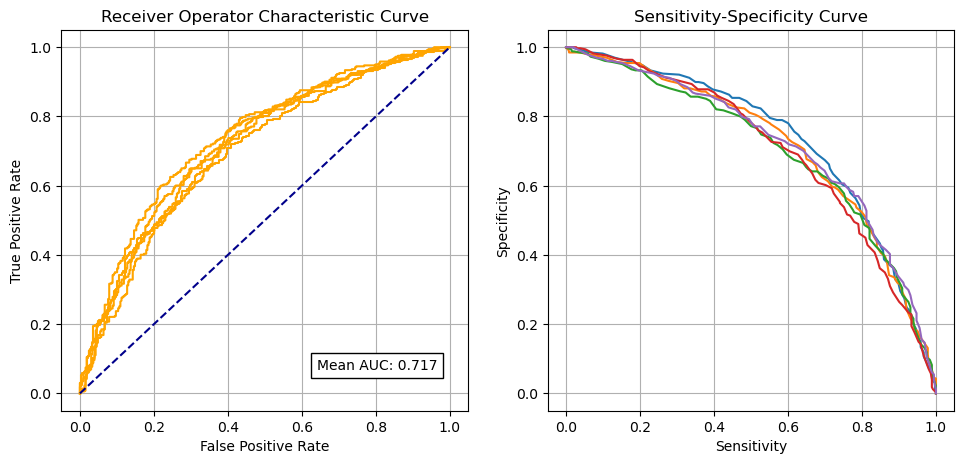

In [20]:
fig = plt.figure(figsize=(10,5))

# Plot ROC
ax1 = fig.add_subplot(121)
for i in range(5):
    ax1.plot(k_fold_fpr[i], k_fold_tpr[i], color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'Mean AUC: {mean_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)

# Plot sensitivity-specificity
ax2 = fig.add_subplot(122)
for i in range(5):
    ax2.plot(k_fold_sensitivity[i], k_fold_specificity[i])
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Specificity')
ax2.set_title('Sensitivity-Specificity Curve')
plt.grid(True)


plt.tight_layout(pad=2)
plt.savefig(f'./output/{notebook}_decision_comparison_roc_sens_spec_key_features.jpg', dpi=300)

plt.show()

### Identify cross-over of sensitivity and specificity

In [21]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

In [22]:
intersections = []
for i in range(5):
    sens = np.array(k_fold_sensitivity[i])
    spec = np.array(k_fold_specificity[i])
    df = pd.DataFrame()
    df['sensitivity'] = sens
    df['specificity'] = spec
    df['spec greater sens'] = spec > sens

    # find last index for senitivity being greater than specificity 
    mask = df['spec greater sens'] == False
    last_id_sens_greater_spec = np.max(df[mask].index)
    locs = [last_id_sens_greater_spec, last_id_sens_greater_spec + 1]
    points = df.iloc[locs][['sensitivity', 'specificity']]

    # Get intersetction with line of x=y
    a1 = list(points.iloc[0].values)
    a2 = list(points.iloc[1].values)
    b1 = [0, 0]
    b2 = [1, 1]

    intersections.append(get_intersect(a1, a2, b1, b2)[0])

mean_intersection = np.mean(intersections)
sd_intersection = np.std(intersections)
print (f'\nMean intersection: {mean_intersection:0.4f}')
print (f'SD intersection: {sd_intersection:0.4f}')


Mean intersection: 0.6654
SD intersection: 0.0124


## Shap values

We will look into detailed Shap values for the first train/test split.

### Get Shap values

In [23]:
k_fold_shap_values_extended = []
k_fold_shap_values = []

for k in range(5):
    
    # Set up explainer using typical feature values from training set
    explainer = shap.TreeExplainer(model_kfold[k], X_train_kfold[k])

    # Get Shapley values along with base and features
    shap_values_extended = explainer(X_test_kfold[k])
    k_fold_shap_values_extended.append(shap_values_extended)
    # Shap values exist for each classification in a Tree; 1=give thrombolysis
    shap_values = shap_values_extended.values
    k_fold_shap_values.append(shap_values)       

    print (f'Completed {k+1} of 5')

Completed 1 of 5
Completed 2 of 5
Completed 3 of 5
Completed 4 of 5
Completed 5 of 5


### Get average Shap values for each k-fold

In [24]:
shap_values_mean_kfold = []
features = list(X_train_kfold[0])

for k in range(5):
    shap_values = k_fold_shap_values[k]
    # Get mean Shap values for each feature
    shap_values_mean = pd.DataFrame(index=features)
    shap_values_mean['mean_shap'] = np.mean(shap_values, axis=0)
    shap_values_mean['abs_mean_shap'] = np.abs(shap_values_mean)
    shap_values_mean['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
    shap_values_mean['rank'] = shap_values_mean['mean_abs_shap'].rank(
        ascending=False).values
    shap_values_mean.sort_index()
    shap_values_mean_kfold.append(shap_values_mean)

### Examine consistency across top Shap values (mean |Shap|)

'Raw' Shap values from XGBoost model are log odds ratios. 

In [25]:
# Build df for k fold values
mean_abs_shap = pd.DataFrame()
for k in range(5):
    mean_abs_shap[f'{k}'] = shap_values_mean_kfold[k]['mean_abs_shap']
    
# Build df to show min, median, and max
mean_abs_shap_summary = pd.DataFrame()
mean_abs_shap_summary['min'] = mean_abs_shap.min(axis=1)
mean_abs_shap_summary['median'] = mean_abs_shap.median(axis=1) 
mean_abs_shap_summary['max'] = mean_abs_shap.max(axis=1)
mean_abs_shap_summary.sort_values('median', inplace=True, ascending=False)

In [26]:
top_10_shap = list(mean_abs_shap_summary.head(10).index)

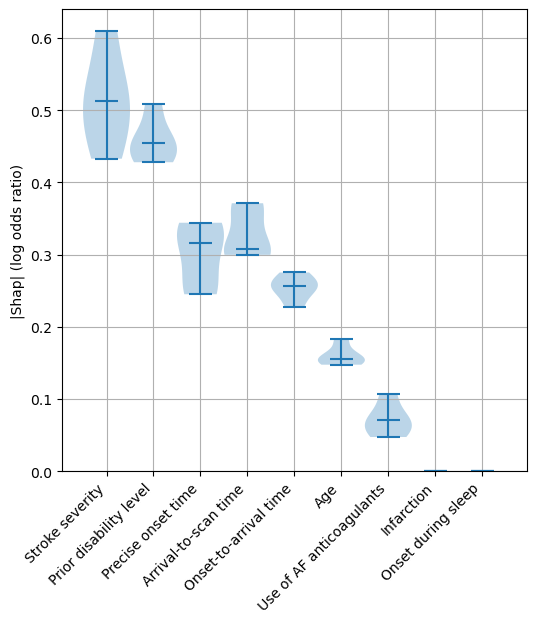

In [27]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.violinplot(mean_abs_shap.loc[top_10_shap].T,
              showmedians=True,
              widths=1)
ax1.set_ylim(0)
labels = top_10_shap
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.grid(which='both')
ax1.set_ylabel('|Shap| (log odds ratio)')
plt.savefig(f'./output/{notebook}_decision_comparison_shap_violin_key_features.jpg', dpi=300)
plt.show()

## Examine consitency of feature importances

In [28]:
# Build df for k fold values
importances_df = pd.DataFrame()
for k in range(5):
    importances_df[f'{k}'] = importances_kfold[k]

# Build df to show min, median, and max
importances_summary = pd.DataFrame()
importances_summary['min'] = importances_df.min(axis=1)
importances_summary['median'] = importances_df.median(axis=1) 
importances_summary['max'] = importances_df.max(axis=1)
importances_summary.sort_values('median', inplace=True, ascending=False)
importance_features_index = list(importances_summary.index)
# Add feature names back in
importances_summary['feature'] = \
    [list(X_train)[feat] for feat in importance_features_index]
importances_summary.set_index('feature', inplace=True)

In [29]:
importances_summary

,min,median,max
feature,,,
Precise onset time,0.314021,0.382470,0.396576
Prior disability level,0.172117,0.185695,0.233592
Use of AF anticoagulants,0.175251,0.183784,0.247513
Stroke severity,0.082731,0.087728,0.096004
Arrival-to-scan time,0.055345,0.060536,0.064322
Onset-to-arrival time,0.047543,0.053195,0.060336
Age,0.041852,0.047126,0.056705
Infarction,0.000000,0.000000,0.000000
Onset during sleep,0.000000,0.000000,0.000000


In [30]:
top_10_importances = list(importances_summary.head(10).index)

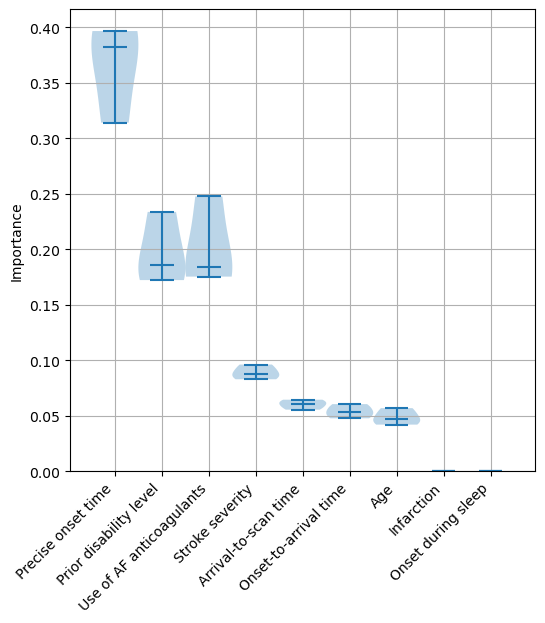

In [31]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.violinplot(importances_summary.loc[top_10_importances].T,
              showmedians=True,
              widths=1)
ax1.set_ylim(0)
labels = top_10_importances
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.grid(which='both')
ax1.set_ylabel('Importance')
plt.savefig('output/06_decision_comparison_importance_violin_key_features.jpg', dpi=300)
plt.show()

### Compare top 10 Shap and importances

In [32]:
compare_shap_importance = pd.DataFrame()
compare_shap_importance['Shap'] = mean_abs_shap_summary.head(10).index
compare_shap_importance['Importance'] = importances_summary.head(10).index
compare_shap_importance

,Shap,Importance
0,Stroke severity,Precise onset time
1,Prior disability level,Prior disability level
2,Precise onset time,Use of AF anticoagulants
3,Arrival-to-scan time,Stroke severity
4,Onset-to-arrival time,Arrival-to-scan time
5,Age,Onset-to-arrival time
6,Use of AF anticoagulants,Age
7,Infarction,Infarction
8,Onset during sleep,Onset during sleep


In [33]:
shap_importance = pd.DataFrame()
shap_importance['Shap'] = mean_abs_shap_summary['median']
shap_importance = shap_importance.merge(
    importances_summary['median'], left_index=True, right_index=True)
shap_importance.rename(columns={'median':'Importance'}, inplace=True)
shap_importance.sort_values('Shap', inplace=True, ascending=False)
shap_importance.head(10)

,Shap,Importance
Stroke severity,0.512633,0.087728
Prior disability level,0.454472,0.185695
Precise onset time,0.315900,0.382470
Arrival-to-scan time,0.307353,0.060536
Onset-to-arrival time,0.256092,0.053195
Age,0.155608,0.047126
Use of AF anticoagulants,0.070263,0.183784
Infarction,0.000000,0.000000
Onset during sleep,0.000000,0.000000


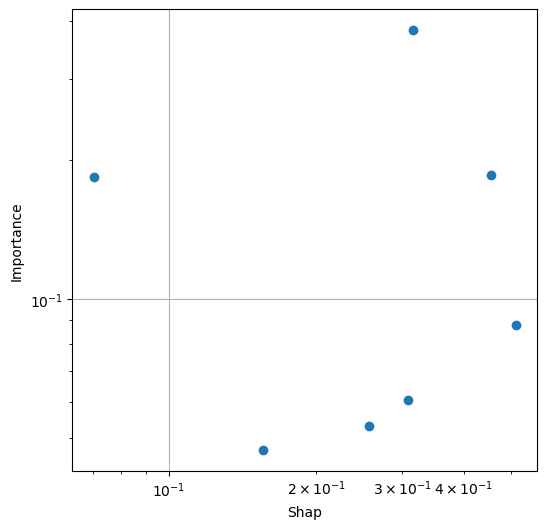

In [34]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(shap_importance['Shap'],
            shap_importance['Importance'])

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Shap')
ax1.set_ylabel('Importance')
ax1.grid()
plt.savefig(
    f'./output/{notebook}_decision_comparison_shap_importance_correlation_key_features.jpg',
    dpi=300)
plt.show()

## Further analysis of one k-fold

Having established that Shap values have good consistency across k-fold replictaes, here we show more detail on Shap using the first k_fold replicate.

In [35]:
# Get all key values from first k fold
model = model_kfold[0]
shap_values = k_fold_shap_values[0]
shap_values_extended = k_fold_shap_values_extended[0]
importances = importances_kfold[0]
y_pred = predicted_kfold[0]
y_prob = predicted_proba_kfold[0]
X_train = X_train_kfold[0]
X_test = X_test_kfold[0]
y_train = y_train_kfold[0]
y_test = y_test_kfold[0]

### Beeswarm plot

A Beeswarm plot shows all points. The feature value for each point is shown by the colour, and its position indicates the Shap value for that instance.

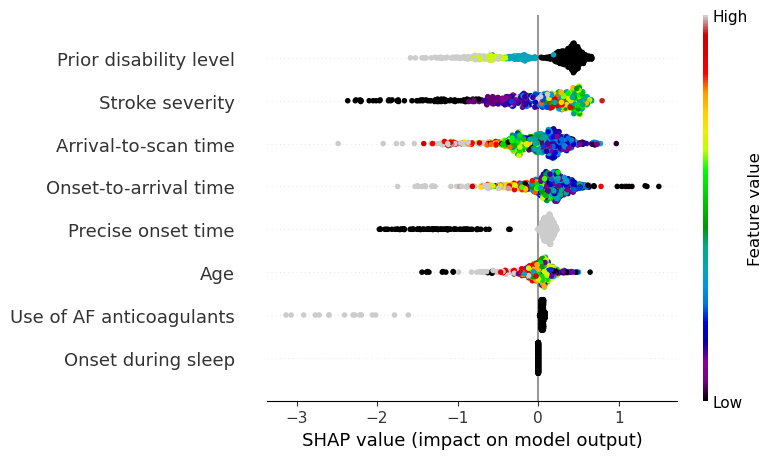

In [36]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values=shap_values, 
                  features=X_test,
                  feature_names=features,
                  max_display=8,
                  cmap=plt.get_cmap('nipy_spectral'), show=False)
plt.savefig('output/06_xgb_decision_comparison_beeswarm_key_features.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

### Plot Waterfall and decision plot plots for instances with low or high probability of receiving thrombolysis

Waterfall plot and decision plots are alternative ways of plotting the influence of features for individual cases.

In [37]:
# Get the location of an example each of low and high probablility
location_low_probability = np.where(y_prob == np.min(y_prob))[0][0]
location_high_probability = np.where(y_prob == np.max(y_prob))[0][0]

An example with low probability of receiving thrombolysis.

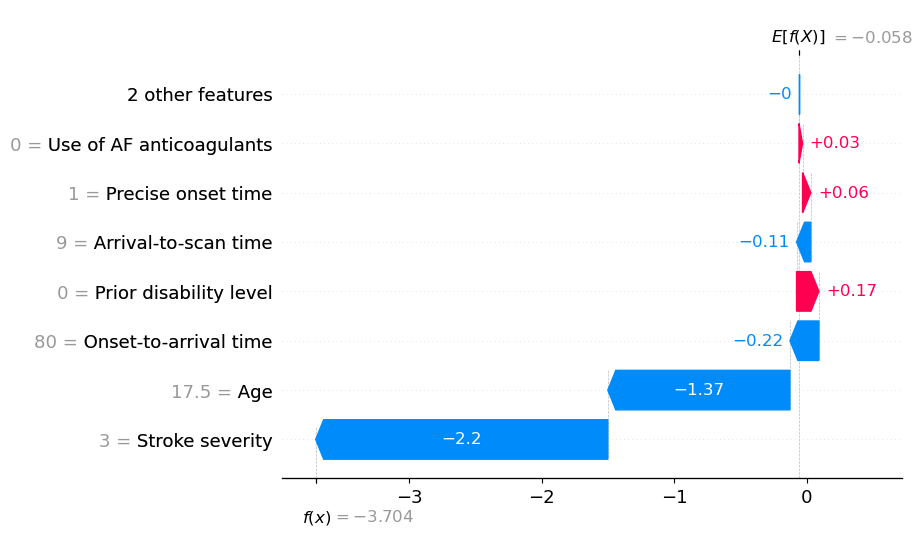

In [38]:
fig = waterfall.waterfall(shap_values_extended[location_low_probability],
                           show=False, max_display=8, y_reverse=True)
plt.savefig(f'./output/{notebook}_xgb_decision_comparison_waterfall_low_key_features.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2, y_reverse=True)
plt.show()

An example with high probability of receiving thrombolysis.

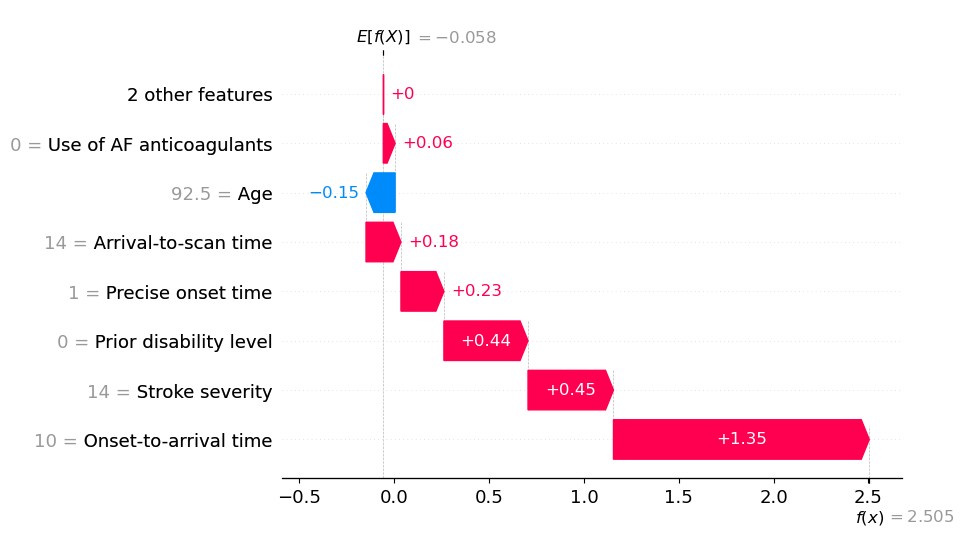

In [39]:
fig = waterfall.waterfall(shap_values_extended[location_high_probability],
                           show=False, max_display=8, y_reverse=True)
plt.savefig(f'./output/{notebook}_xgb_decision_comparison_waterfall_high_key_features.jpg',
            dpi=300, bbox_inches='tight', pad_inches=0.2, y_reverse=True)
plt.show()

### Show the relationship between feature value and Shap value for top 5 influential features.

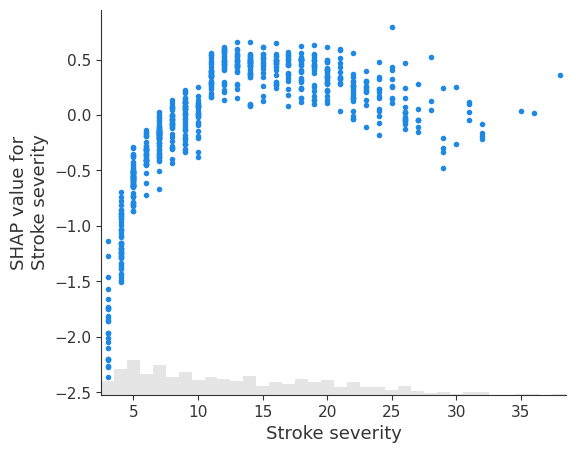

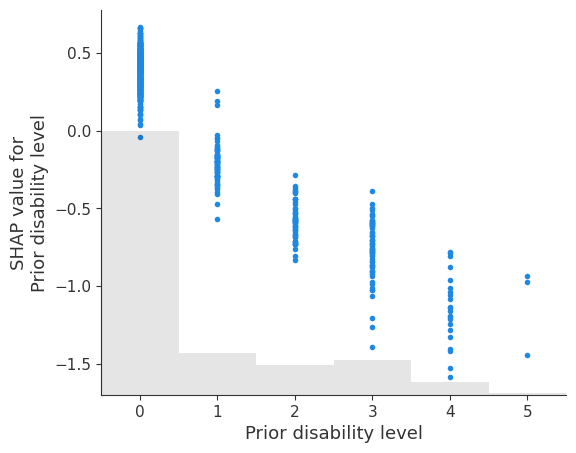

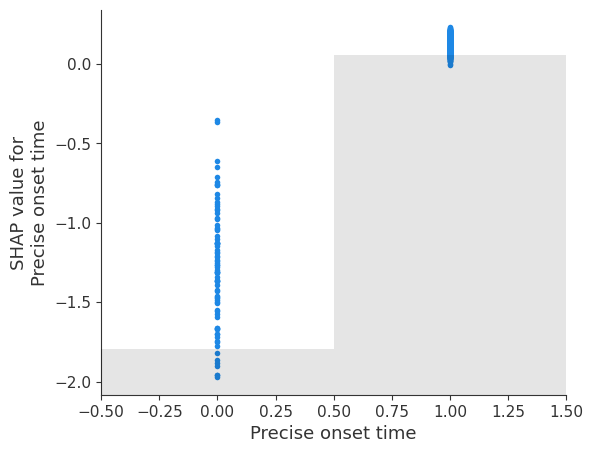

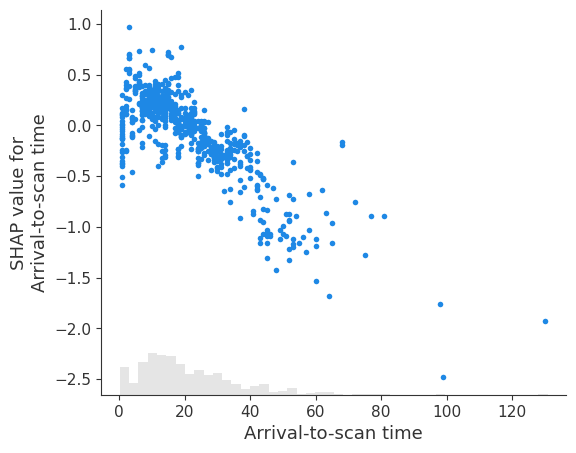

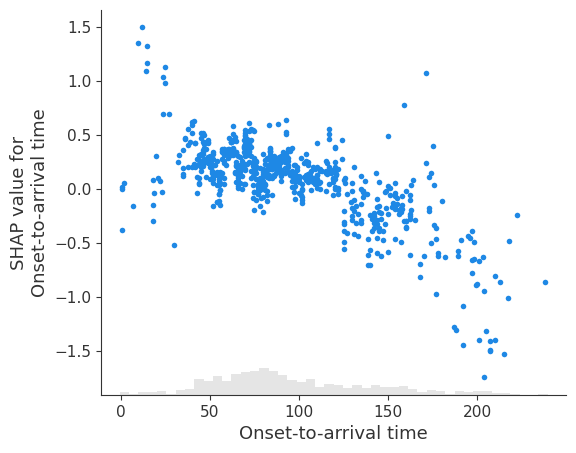

In [40]:
feat_to_show = top_10_shap[0:5]

for feat in feat_to_show:
    shap.plots.scatter(shap_values_extended[:, feat], x_jitter=0)

## Showing waterfall plots using probability values

Though Shap values for XGBoost most accurately describe the effect on log odds ratio of classification, it may be easier for people to understand influence of features using probabilities. Here we plot waterfall plots using probabilities.

A disadvantage of this method is that it distorts the influence of features someone - those features pushing the probability down from a low level to an even lower level get 'squashed' in apparent importance. This distortion is avoided when plotting log odds ratio, but at the cost of using an output that is poorly understandable by many.

In [41]:
# Set up explainer using typical feature values from training set
explainer = shap.TreeExplainer(model, X_train, model_output='probability')

# Get Shapley values along with base and features
shap_values_extended = explainer(X_test)
shap_values = shap_values_extended.values

In [42]:
# Get the location of an example each of low and high probablility

location_low_probability = np.where(y_prob==np.min(y_prob))[0][0]
location_high_probability = np.where(y_prob==np.max(y_prob))[0][0]

An example with low probability of receiving thrombolysis.

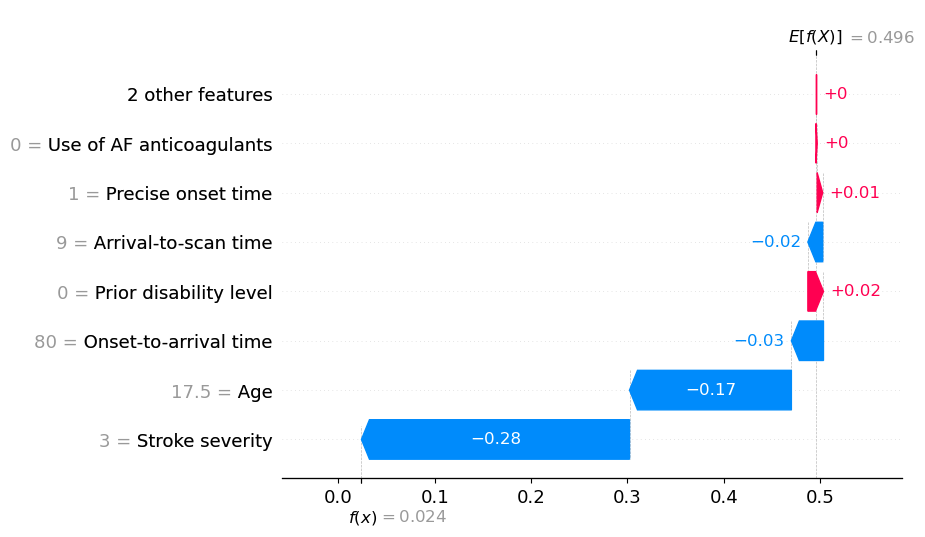

In [44]:
fig = waterfall.waterfall(shap_values_extended[location_low_probability],
                           show=False, max_display=8, y_reverse=True)
plt.savefig(
    f'./output/{notebook}_xgb_decision_comparison_waterfall_low_probability_key_features.jpg', 
    dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

An example with high probability of receiving thrombolysis.

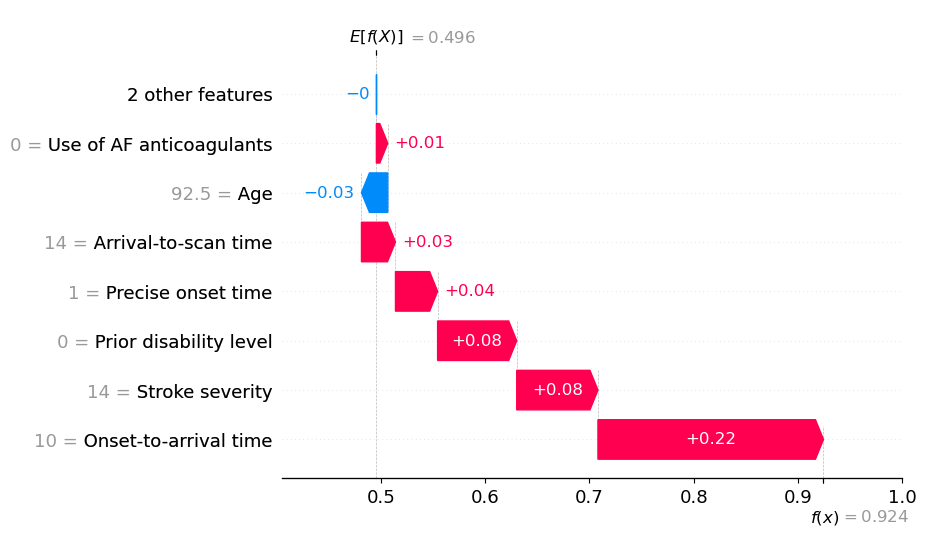

In [45]:
fig = waterfall.waterfall(shap_values_extended[location_high_probability],
                           show=False, max_display=8, y_reverse=True)
plt.savefig(
    f'./output/{notebook}_xgb_decision_comparison_waterfall_high_probability_key_features.jpg', 
    dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()